In [5]:
import sys

sys.path.append("../")

In [6]:
import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [7]:
%config InlineBackend.figure_format = 'retina'

In [8]:
EXPERIMENT_DIR = "../experiments_iterative"

COMPUTE_LIKELIHOODS = False

In [120]:
# DOMAIN = "logo"
# DOMAIN = "clevr"
# DOMAIN = "re2"
DOMAIN = "drawings_nuts_bolts"

CONDITION_STITCH = "stitch"
CONDITION_STITCH_CODEX = "stitch_codex"
CONDITION_STITCH_CODEX_LANGUAGE_HUMAN = "stitch_codex_language_human"
CONDITION_ORACLE = "oracle"
CONDITION_ORACLE_TRAIN_TEST = "oracle_train_test"

# Which conditions to plot
conditions = [
    CONDITION_STITCH,
    CONDITION_STITCH_CODEX,
    CONDITION_STITCH_CODEX_LANGUAGE_HUMAN,
    CONDITION_ORACLE,
    CONDITION_ORACLE_TRAIN_TEST
]

# RANDOM_SEEDS = []
RANDOM_SEEDS = [0, 1]

# ERROR_BAR_COL = "task_name"  # Error bars will show variation across tasks; results from different random seeds will be averaged
ERROR_BAR_COL = "random_seed" # Error bars will show variation across random seeds; results from different tasks will be averaged

In [121]:
NUMERIC_SORT = lambda x: (len(x), x)

In [122]:
def get_log_likelihoods(condition, split):
    results_pattern = os.path.join(
        EXPERIMENT_DIR, "outputs", "domains", DOMAIN, condition, f"seed_*"
    )

    seed_paths = sorted(glob.glob(results_pattern), key=NUMERIC_SORT)
    if not seed_paths:
        raise ValueError(results_pattern)

    df_list = []
    for seed_path in seed_paths:
        random_seed = int(seed_path[len(results_pattern) - 1 :])

        if len(RANDOM_SEEDS) > 0 and random_seed not in RANDOM_SEEDS:
            continue

        print(f"Condition: {condition}, split: {split}, seed: {random_seed}")

        df = get_log_likelihoods_single_replication(condition, split, random_seed)
        df["random_seed"] = random_seed
        df_list.append(df)

    df_concat = pd.concat(df_list, axis=0).reset_index(drop=True)

    # Compute the mean over replications
    AGG_COLS = ["n_frontiers", "description_length"]
    if COMPUTE_LIKELIHOODS:
        AGG_COLS += ["log_likelihood"]
    df_out = df_concat.groupby(
        ["batch_size", ERROR_BAR_COL], sort=False, as_index=False
    )[AGG_COLS].mean()

    return df_out


def get_log_likelihoods_single_replication(condition, split, random_seed):
    data = []

    results_pattern = os.path.join(
        EXPERIMENT_DIR,
        "outputs",
        "domains",
        DOMAIN,
        condition,
        f"seed_{random_seed}",
        f"{condition}_*",
    )

    for path in sorted(glob.glob(results_pattern), key=NUMERIC_SORT):
        try:
            config_json_path = os.path.join(path, "config.json")
            with open(config_json_path, "r") as f:
                config = json.load(f)
            global_batch_size = config["experiment_iterator"]["task_batcher"]["params"][
                "global_batch_size"
            ]

            test_likelihoods_json_path = os.path.join(path, "0", "test_likelihoods.json")
            with open(test_likelihoods_json_path, "r") as f:
                likelihoods_data = json.load(f)

            stitch_frontiers_json_path = os.path.join(
                path, "0", split, "stitch_frontiers.json"
            )
            with open(stitch_frontiers_json_path, "r") as f:
                stitch_frontiers_data = json.load(f)

            for task_name, dl_list in likelihoods_data["description_lengths_by_task"][
                "test"
            ].items():
                d = {
                    "batch_size": global_batch_size,
                    "task_name": task_name,
                    "description_length": dl_list[0],
                    "n_frontiers": len(stitch_frontiers_data["frontiers"]),
                }
                if COMPUTE_LIKELIHOODS:
                    d["log_likelihood"] = likelihoods_data["log_likelihoods_by_task"][
                        "test"
                    ][task_name][0]

                data.append(d)
        except:
            continue

    df = pd.DataFrame(data)
    return df

In [135]:
dfs = []
for condition in conditions:
    if condition == CONDITION_STITCH:
        df = get_log_likelihoods(CONDITION_STITCH, "train")
        df["condition"] = "Stitch"
    elif condition == CONDITION_STITCH_CODEX:
        df = get_log_likelihoods(CONDITION_STITCH_CODEX, "train")
        df["condition"] = "Stitch + Codex"
    elif condition == CONDITION_STITCH_CODEX_LANGUAGE_HUMAN:
        df = get_log_likelihoods(CONDITION_STITCH_CODEX_LANGUAGE_HUMAN, "train")
        df["condition"] = "Stitch + Codex P(p' | (p, l)) (Human)" 
    elif condition == CONDITION_ORACLE:
        df = get_log_likelihoods(CONDITION_ORACLE, "test")
        df["condition"] = "Oracle (Test)"
    elif condition == CONDITION_ORACLE_TRAIN_TEST:
        df = get_log_likelihoods(CONDITION_ORACLE_TRAIN_TEST, "train_test")
        df["condition"] = "Oracle (Train + Test)"
    dfs.append(df)

Condition: stitch, split: train, seed: 0
Condition: stitch_codex, split: train, seed: 0
Condition: stitch_codex_language_human, split: train, seed: 0
Condition: stitch_codex_language_human, split: train, seed: 1
Condition: oracle, split: test, seed: 0
Condition: oracle_train_test, split: train_test, seed: 0


In [136]:
df = pd.concat(dfs, axis=0).reset_index(drop=True)
df.batch_size = df.batch_size.astype(int)
BATCH_SIZES = sorted(df.batch_size.unique().tolist())
BATCH_SIZES

[5, 10, 15, 25, 50, 100, 200, 250]

In [137]:
df

,batch_size,random_seed,n_frontiers,description_length,condition
0,5,0,5.0,79.96,Stitch
1,10,0,10.0,71.26,Stitch
2,15,0,15.0,56.08,Stitch
3,25,0,25.0,42.42,Stitch
4,50,0,50.0,33.98,Stitch
5,100,0,100.0,8.16,Stitch
6,200,0,200.0,7.42,Stitch
7,250,0,200.0,7.42,Stitch
8,5,0,24.0,63.90,Stitch + Codex
9,10,0,34.0,38.76,Stitch + Codex


<AxesSubplot:xlabel='batch_size', ylabel='n_frontiers'>

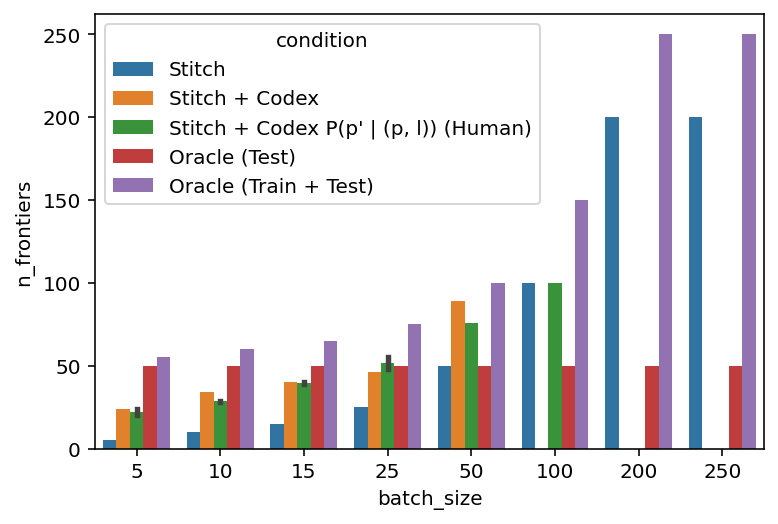

In [138]:
sns.barplot(data=df, x="batch_size", y="n_frontiers", hue="condition")

[Text(0.5, 1.0, 'drawings_nuts_bolts')]

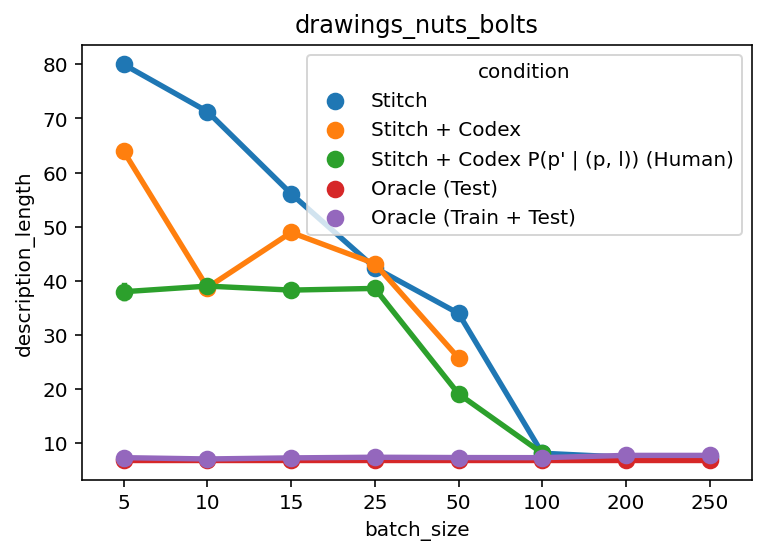

In [139]:
sns.pointplot(data=df, x="batch_size", y="description_length", hue="condition").set(title=DOMAIN)

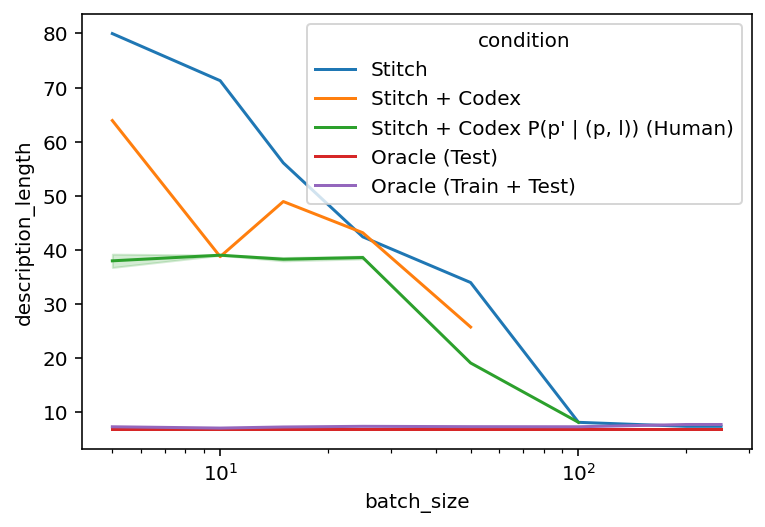

In [140]:
g = sns.lineplot(data=df, x="batch_size", y="description_length", hue="condition")
g.set(xscale="log");

In [101]:
if COMPUTE_LIKELIHOODS:
    sns.pointplot(data=df, x="batch_size", y="log_likelihood", hue="condition")

In [102]:
if COMPUTE_LIKELIHOODS:
    g = sns.lineplot(data=df, x="batch_size", y="log_likelihood", hue="condition")
    g.set(xscale="log");

In [20]:
if COMPUTE_LIKELIHOODS:
    sns.scatterplot(
        data=df, x="description_length", y="log_likelihood", hue="condition", alpha=0.25
    )

# What programs does Codex generate?

In [ ]:
def get_codex_programs():
    results_pattern = os.path.join(
        EXPERIMENT_DIR, "outputs", "domains", DOMAIN, CONDITION_STITCH_CODEX, f"seed_*"
    )
    seed_paths = sorted(glob.glob(results_pattern), key=NUMERIC_SORT)
    if not seed_paths:
        raise ValueError(results_pattern)
    print(seed_paths)

    df_list = []

    for seed_path in seed_paths:
        random_seed = int(seed_path[len(results_pattern) - 1 :])

        for batch_size in BATCH_SIZES:
            path = os.path.join(
                seed_path,
                f"{CONDITION_STITCH_CODEX}_{batch_size}/0/codex_query_results.json",
            )

            with open(path, "r") as f:
                codex_query_results = json.load(f)

            data = []
            for p in codex_query_results["prompt_programs"]:
                data.append(
                    {
                        "program": p,
                        "origin": "train",
                        "valid": True,
                    }
                )
            for p in codex_query_results["programs_valid"]:
                data.append(
                    {
                        "program": p,
                        "origin": "codex",
                        "valid": True,
                    }
                )
            for p in codex_query_results["programs_invalid"]:
                data.append(
                    {
                        "program": p,
                        "origin": "codex",
                        "valid": False,
                    }
                )

            df = pd.DataFrame(data)
            df["program_str_len"] = df.program.str.len()
            df["batch_size"] = batch_size
            df["random_seed"] = random_seed

            tps = df[df["origin"] == "train"]["program"]
            print(tps)

            train_programs = set(df[df["origin"] == "train"]["program"].tolist())
            df["copied_from_train"] = [
                (row["origin"] == "codex") and (row["program"] in train_programs)
                for _, row in df.iterrows()
            ]

            df_list.append(df)

        #         print(
        #             f"+ From {batch_size} training programs, Codex generated {len(df[df.origin == 'codex'])} programs, for a total of {len(df)} programs."
        #         )
        #         print(
        #             f"+ Of these, {len(df[(df.origin == 'codex') & (df.valid)])} were valid and {len(df[(df.origin == 'codex') & (~df.valid)])} were invalid."
        #         )
        #         print(
        #             f"+ In total, there were {df['program'].nunique()} unique programs; {df[df.valid]['program'].nunique()} were valid."
        #         )

        #         copied_programs = set(codex_query_results["programs_valid"]) & set(
        #             codex_query_results["prompt_programs"]
        #         )
        #         print(
        #             f"+ {len(copied_programs)} of the Codex programs were direct copies from the training data."
        #         )

        return pd.concat(df_list).reset_index(drop=True)

In [ ]:
df_codex = get_codex_programs()

In [ ]:
df_codex

In [ ]:
plt.title("Percentage of valid programs")
sns.barplot(data=df_codex, x="batch_size", y="valid", hue="origin");

In [ ]:
plt.title("Program string length")
sns.violinplot(data=df_codex, x="batch_size", y="program_str_len", hue="origin");

In [ ]:
plt.title("Count of unique programs")
sns.pointplot(
    data=df_codex.groupby("batch_size").nunique().reset_index(),
    x="batch_size",
    y="program",
);

In [ ]:
plt.title("Count of programs copied from train")
sns.pointplot(
    data=df_codex.groupby("batch_size").sum().reset_index(),
    x="batch_size",
    y="copied_from_train",
);

In [ ]:
sns.displot(
    data=df_codex, x="program_str_len", hue="valid", col="origin", row="batch_size"
);

# What inventions are in the libraries?

In [ ]:
def get_library_inventions(condition, split):
    data = []
    for batch_size in BATCH_SIZES:
        path = os.path.join(
            EXPERIMENT_DIR,
            "outputs",
            "domains",
            DOMAIN,
            condition,
            f"{condition}_{batch_size}",
            "0",
            split,
            "stitch_output.json",
        )
        # path = f"../experiments/outputs/{DOMAIN}/{experiment_id}/{experiment_id}_{batch_size}/0/{split}/stitch_output.json"

        with open(path, "r") as f:
            stitch_output_data = json.load(f)

        df = pd.DataFrame(stitch_output_data["invs"])[
            ["name", "arity", "utility", "multiplier", "body", "dreamcoder"]
        ]
        df["batch_size"] = batch_size
        data.append(df)

    return pd.concat(data, axis=0).reset_index(drop=True)

In [ ]:
df_libraries_baseline = get_library_inventions(CONDITION_STITCH, "train")
df_libraries_baseline["condition"] = "baseline"

df_libraries_codex = get_library_inventions(CONDITION_STITCH_CODEX, "train")
df_libraries_codex["condition"] = "codex"

df_libraries_test = get_library_inventions(CONDITION_ORACLE, "test")
df_libraries_test["condition"] = "test"

df_libraries = pd.concat(
    [df_libraries_baseline, df_libraries_codex, df_libraries_test], axis=0
).reset_index(drop=True)

In [ ]:
data_overlap = []
for batch_size, group in df_libraries.groupby("batch_size"):
    fns_baseline = set(group[group.condition == "baseline"].dreamcoder)
    fns_codex = set(group[group.condition == "codex"].dreamcoder)
    fns_test = set(group[group.condition == "test"].dreamcoder)
    data_overlap.append(
        {
            "batch_size": int(batch_size),
            "utility_baseline": group[group.condition == "baseline"]["utility"].sum(),
            "utility_codex": group[group.condition == "codex"]["utility"].sum(),
            "utility_test": group[group.condition == "test"]["utility"].sum(),
            "n_baseline": len(fns_baseline),
            "fns_baseline": fns_baseline,
            "n_codex": len(fns_codex),
            "fns_codex": fns_codex,
            "n_test": len(fns_test),
            "fns_test": fns_test,
            "n_baseline_only": len(fns_baseline - fns_codex),
            "fns_baseline_only": fns_baseline - fns_codex,
            "n_codex_only": len(fns_codex - fns_baseline),
            "fns_codex_only": fns_codex - fns_baseline,
            "n_overlap": len(fns_baseline & fns_codex),
            "fns_overlap": (fns_baseline & fns_codex),
            "n_baseline_test": len(fns_baseline & fns_test),
            "n_codex_test": len(fns_codex & fns_test),
        }
    )

In [ ]:
df_overlap = pd.DataFrame(data_overlap)
df_overlap

In [ ]:
df_overlap_long = df_overlap.rename(
    dict(
        zip(
            ["n_baseline_only", "n_codex_only", "n_overlap"],
            ["baseline_only", "codex_only", "overlap"],
        )
    ),
    axis="columns",
)
df_overlap_long = df_overlap_long.melt(
    id_vars="batch_size",
    value_vars=["baseline_only", "codex_only", "overlap"],
    var_name="library",
    value_name="Inventions (count)",
)

plt.title("Overlap between Baseline and Codex inventions")
sns.barplot(data=df_overlap_long, x="batch_size", y="Inventions (count)", hue="library")

In [ ]:
df_overlap_long = df_overlap.rename(
    dict(
        zip(
            ["n_baseline_test", "n_codex_test", "n_test"],
            ["Stitch", "Stitch + Codex", "Oracle"],
        )
    ),
    axis="columns",
)
df_overlap_long = df_overlap_long.melt(
    id_vars="batch_size",
    value_vars=["Stitch", "Stitch + Codex", "Oracle"],
    var_name="library",
    value_name="Oracle inventions discovered (count)",
)

plt.title("Discovery of oracle (test set) inventions")
sns.pointplot(
    data=df_overlap_long,
    x="batch_size",
    y="Oracle inventions discovered (count)",
    hue="library",
)

In [ ]:
df_overlap_long

In [ ]:
from matplotlib_venn import venn2, venn3

In [ ]:
os.makedirs("library_venn_diagrams", exist_ok=True)
os.makedirs("library_venn_diagrams/venn2", exist_ok=True)
os.makedirs("library_venn_diagrams/venn3", exist_ok=True)

In [ ]:
for i, row in df_overlap.iterrows():
    plt.figure()
    venn2(
        subsets=(row["n_baseline_only"], row["n_codex_only"], row["n_overlap"]),
        set_labels=("Baseline", "Codex"),
    )
    plt.title("Batch size: " + str(row["batch_size"]))
    plt.savefig(
        f"library_venn_diagrams/venn2/batch_{row['batch_size']:03d}.png", dpi=144
    )

In [ ]:
for batch_size, group in df_libraries.groupby("batch_size"):
    fns_baseline = set(group[group.condition == "baseline"].dreamcoder)
    fns_codex = set(group[group.condition == "codex"].dreamcoder)
    fns_test = set(group[group.condition == "test"].dreamcoder)
    plt.figure()
    venn3(
        [fns_baseline, fns_codex, fns_test],
        set_labels=("Baseline", "Codex", "Oracle"),
    )
    plt.title("Batch size: " + str(batch_size))
    plt.savefig(f"library_venn_diagrams/venn3/batch_{int(batch_size):03d}.png", dpi=144)